<a href="https://colab.research.google.com/github/mc-ivan/data-mining-final-lab/blob/main/dataset/DataMiningFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis y modelado del dataset de crímenes en Los Ángeles (2020-presente)

In [1]:
# ==============================
# 0. Importacion de Librerias
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
# ==============================
# 1. Cargar el dataset
# ==============================
url = "https://raw.githubusercontent.com/mc-ivan/data-mining-final-lab/main/dataset/Crime_Data_from_2020_to_Present.csv.gz"

print("Cargando dataset...")
df = pd.read_csv(url, compression='gzip')

print(f"Dataset cargado con {df.shape[0]:,} filas y {df.shape[1]} columnas")
df.head()

Cargando dataset...
Dataset cargado con 1,004,991 filas y 28 columnas


,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,211507896,04/11/2021 12:00:00 AM,11/07/2020 12:00:00 AM,845,15,N Hollywood,1502,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,7800 BEEMAN AV,NaN,34.2124,-118.4092
1,201516622,10/21/2020 12:00:00 AM,10/18/2020 12:00:00 AM,1845,15,N Hollywood,1521,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",...,IC,Invest Cont,230.0,NaN,NaN,NaN,ATOLL AV,N GAULT,34.1993,-118.4203
2,240913563,12/10/2024 12:00:00 AM,10/30/2020 12:00:00 AM,1240,9,Van Nuys,933,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,14600 SYLVAN ST,NaN,34.1847,-118.4509
3,210704711,12/24/2020 12:00:00 AM,12/24/2020 12:00:00 AM,1310,7,Wilshire,782,1,331,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,...,IC,Invest Cont,331.0,NaN,NaN,NaN,6000 COMEY AV,NaN,34.0339,-118.3747
4,201418201,10/03/2020 12:00:00 AM,09/29/2020 12:00:00 AM,1830,14,Pacific,1454,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),...,IC,Invest Cont,420.0,NaN,NaN,NaN,4700 LA VILLA MARINA,NaN,33.9813,-118.4350


In [6]:
# ==============================
# 2. Exploración inicial
# ==============================
print("\nInformación general del dataset:")
print(df.info())

print("\nValores nulos por columna:")
print(df.isnull().sum())


Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004991 entries, 0 to 1004990
Data columns (total 28 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   DR_NO           1004991 non-null  int64  
 1   Date Rptd       1004991 non-null  object 
 2   DATE OCC        1004991 non-null  object 
 3   TIME OCC        1004991 non-null  int64  
 4   AREA            1004991 non-null  int64  
 5   AREA NAME       1004991 non-null  object 
 6   Rpt Dist No     1004991 non-null  int64  
 7   Part 1-2        1004991 non-null  int64  
 8   Crm Cd          1004991 non-null  int64  
 9   Crm Cd Desc     1004991 non-null  object 
 10  Mocodes         853372 non-null   object 
 11  Vict Age        1004991 non-null  int64  
 12  Vict Sex        860347 non-null   object 
 13  Vict Descent    860335 non-null   object 
 14  Premis Cd       1004975 non-null  float64
 15  Premis Desc     1004403 non-null  object 
 16  We

In [9]:
# ==============================
# 3. Preprocesamiento
# ==============================
# Ejemplo: convertir fechas
if 'DATE OCC' in df.columns:
    df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], errors='coerce')

# Rellenar valores nulos en columnas numéricas con la media
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# Eliminar filas con valores nulos restantes
df = df.dropna()
df.shape

(75550, 28)

In [10]:
# ==============================
# 4. Selección de variables para ejemplo de modelo
# ==============================
# Nota: Este dataset es grande y con muchas variables categóricas, aquí hacemos un ejemplo sencillo
# Supongamos que queremos predecir si un crimen es violento (ejemplo ficticio)
if 'Crm Cd Desc' in df.columns:
    df['Violent'] = df['Crm Cd Desc'].str.contains('ASSAULT|HOMICIDE|RAPE|ROBBERY', case=False, na=False).astype(int)
else:
    raise ValueError("No se encontró la columna 'Crm Cd Desc' en el dataset.")

# Usaremos latitud y longitud como variables predictoras (solo a modo de ejemplo)
if {'LAT', 'LON'}.issubset(df.columns):
    X = df[['LAT', 'LON']]
    y = df['Violent']
else:
    raise ValueError("No se encontraron las columnas 'LAT' y 'LON' en el dataset.")

In [11]:
# ==============================
# 5. División de datos y escalado
# ==============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
# ==============================
# 6. Entrenamiento del modelo
# ==============================
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [14]:
# ==============================
# 7. Evaluación
# ==============================
y_pred = model.predict(X_test)

print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


Matriz de confusión:
[[    0  3099]
 [    0 12011]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3099
           1       0.79      1.00      0.89     12011

    accuracy                           0.79     15110
   macro avg       0.40      0.50      0.44     15110
weighted avg       0.63      0.79      0.70     15110



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


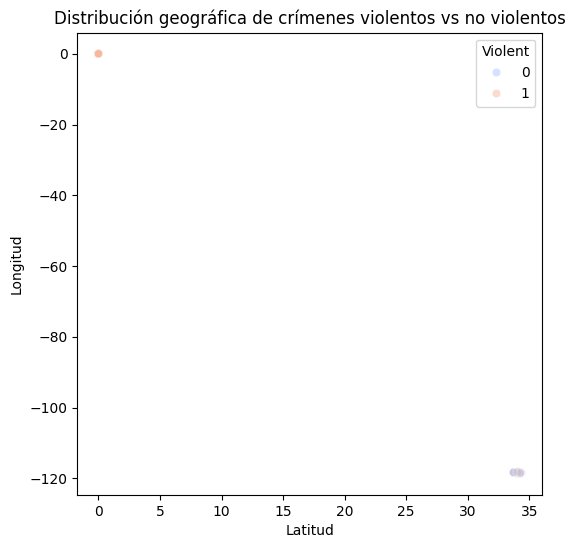

In [15]:
# ==============================
# 8. Visualización
# ==============================
plt.figure(figsize=(6, 6))
sns.scatterplot(x=X['LAT'], y=X['LON'], hue=y, alpha=0.5, palette='coolwarm')
plt.title("Distribución geográfica de crímenes violentos vs no violentos")
plt.xlabel("Latitud")
plt.ylabel("Longitud")
plt.show()


# Opcion 2

>> Cargando dataset desde GitHub (gzip)...
Shape: (1004991, 28)
Columnas (primeras 20): ['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME', 'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc']
[fig] outputs_crime_project/01_nulls_top30.png


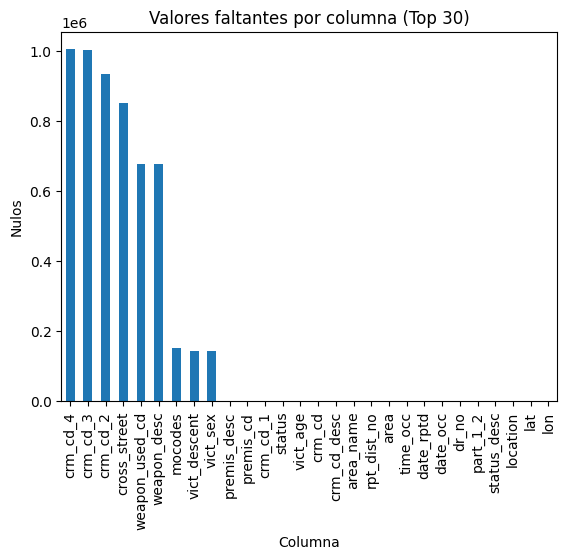

[fig] outputs_crime_project/02_rows_before_after.png


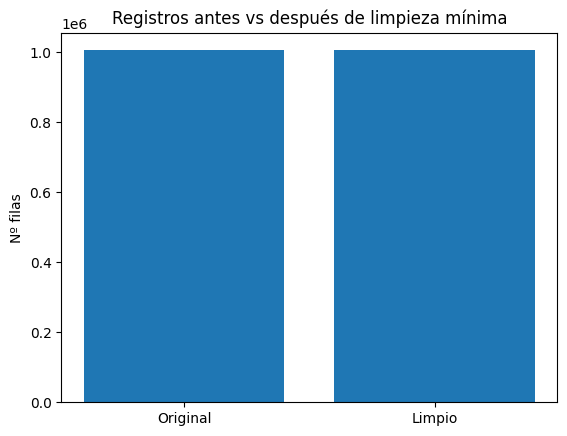

[fig] outputs_crime_project/03_top_crimes.png


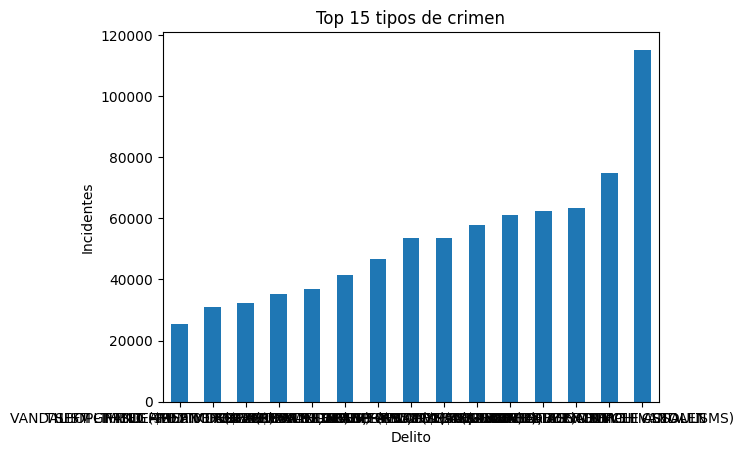

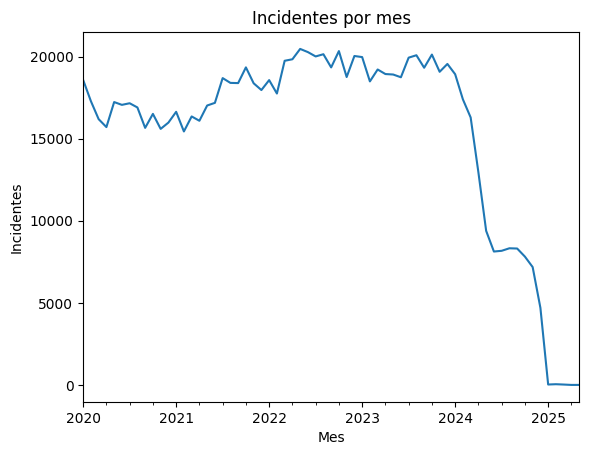

[fig] outputs_crime_project/03_monthly_series.png


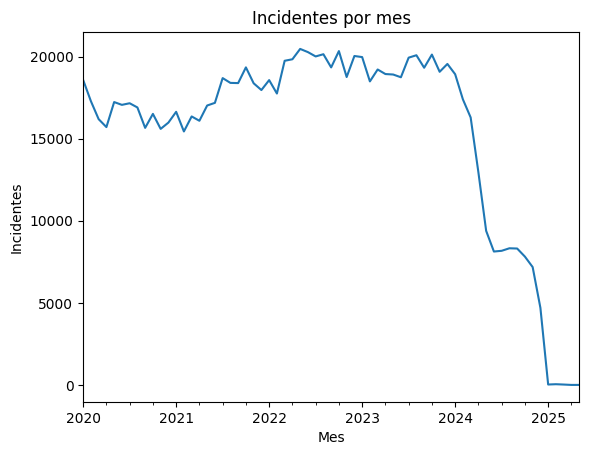

[fig] outputs_crime_project/03_dayofweek.png


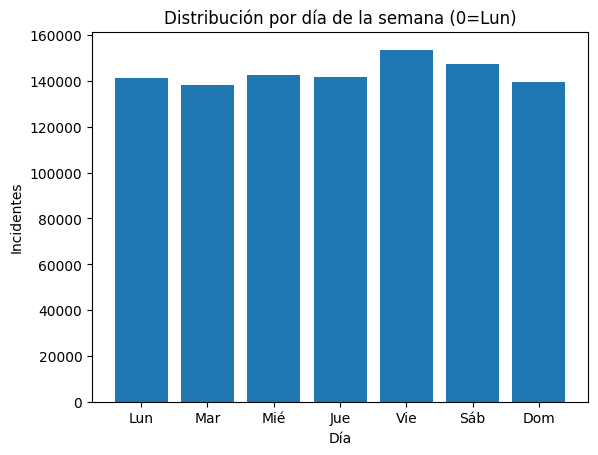

[fig] outputs_crime_project/03_victim_age_hist.png


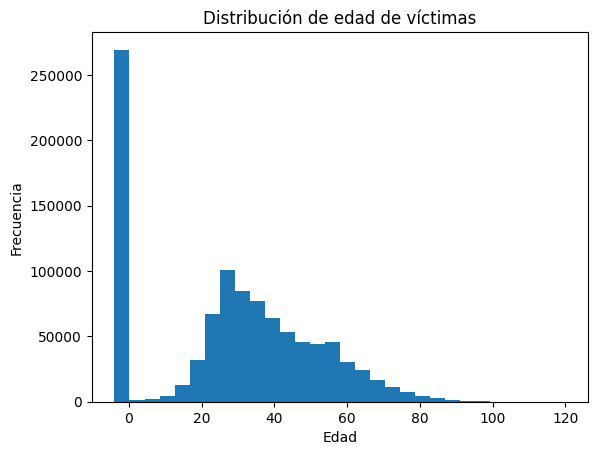

[fig] outputs_crime_project/03_corr_heatmap.png


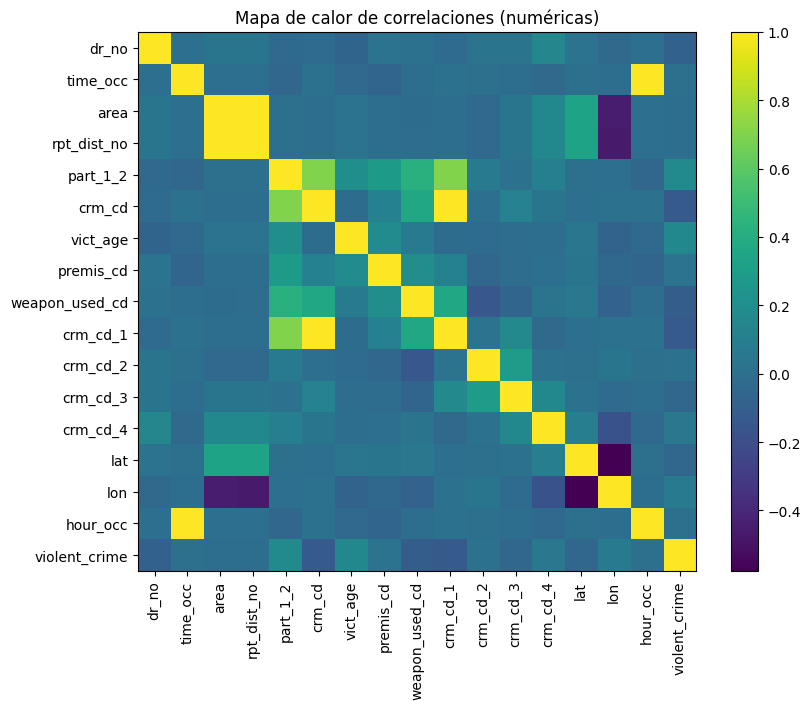


[OLS] Resumen:
                            OLS Regression Results                            
Dep. Variable:              incidents   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     16.96
Date:                Thu, 14 Aug 2025   Prob (F-statistic):           1.33e-06
Time:                        01:03:39   Log-Likelihood:                -641.44
No. Observations:                  65   AIC:                             1289.
Df Residuals:                      62   BIC:                             1295.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.416e+06   7.68e+05    

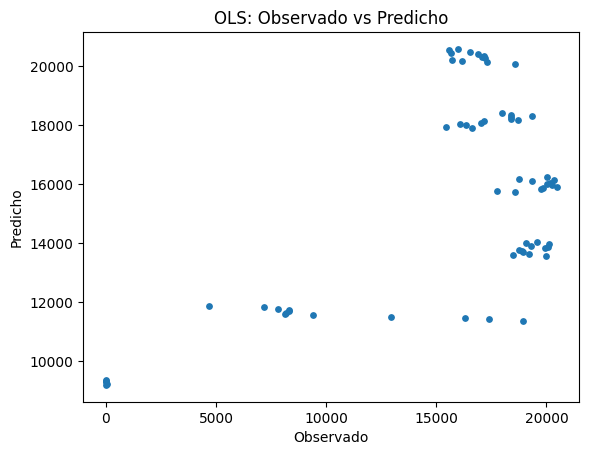

[fig] outputs_crime_project/04_ols_residuals.png


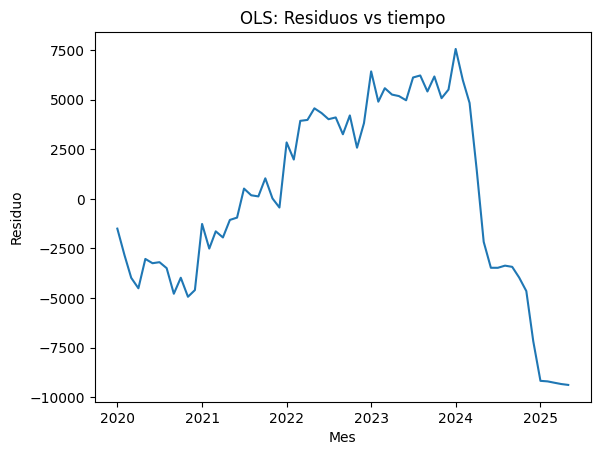

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [17]:
# ============================================================
# Proyecto: Crime Data from 2020 to Present (LAPD)
# Pipeline CRISP-DM con gráficas en cada etapa
# Autor: mci
# ============================================================

# ======================
# 0) IMPORTS & CONFIG
# ======================
import io, json, math, os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from urllib.request import urlopen

# ML / Stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    RocCurveDisplay, ConfusionMatrixDisplay, mean_squared_error
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.tools import add_constant
from statsmodels.discrete.discrete_model import Logit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

try:
    from pmdarima import auto_arima
    USE_ARIMA = True
except Exception:
    USE_ARIMA = False

# ---------- Rutas y parámetros ----------
RAW_URL = "https://raw.githubusercontent.com/mc-ivan/data-mining-final-lab/main/dataset/Crime_Data_from_2020_to_Present.csv.gz"
OUT = "outputs_crime_project"
os.makedirs(OUT, exist_ok=True)

RANDOM_STATE = 42
ROW_SAMPLE = None       # usa None para TODO; o un número (p.ej. 300_000) para desarrollo
TOP_N_CATS = 25         # recorta cardinalidad en categóricas "top N + 'Other'"

# ============================
# Helpers de visualización
# ============================
def savefig(name):
    path = os.path.join(OUT, name)
    plt.savefig(path, bbox_inches="tight", dpi=140)
    print(f"[fig] {path}")

def bar_from_series(s, title, xlabel="", ylabel="Cantidad", fname=None, rot=0):
    plt.figure()
    s.plot(kind="bar")
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel); plt.xticks(rotation=rot)
    if fname: savefig(fname)
    plt.show()

def line_from_series(s, title, xlabel="", ylabel=""):
    plt.figure()
    s.plot(kind="line")
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.show()

def heatmap_corr(df, title, fname=None):
    corr = df.corr(numeric_only=True)
    plt.figure(figsize=(9,7))
    plt.imshow(corr, aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.title(title)
    if fname: savefig(fname)
    plt.show()

def top_n_or_other(series, n=20, other="Other"):
    vc = series.value_counts()
    keep = set(vc.index[:n])
    return series.apply(lambda x: x if x in keep else other)

# ======================
# 1) CARGA & ENTENDIMIENTO
# ======================
print(">> Cargando dataset desde GitHub (gzip)...")
with urlopen(RAW_URL) as resp:
    raw = resp.read()
buf = io.BytesIO(raw)
df = pd.read_csv(buf, compression='gzip', low_memory=False, nrows=ROW_SAMPLE)

print("Shape:", df.shape)
print("Columnas (primeras 20):", df.columns[:20].tolist())

# Estándar de columnas (snake_case)
df.columns = (
    df.columns.str.strip()
               .str.replace(r"[^0-9a-zA-Z]+", "_", regex=True)
               .str.lower()
)

# Gráfico: valores nulos por columna (top 30)
nulls = df.isna().sum().sort_values(ascending=False)
bar_from_series(nulls.head(30), "Valores faltantes por columna (Top 30)", "Columna", "Nulos", "01_nulls_top30.png", rot=90)

# ======================
# 2) PREPROCESAMIENTO
# ======================
# 2.1 Parse de fechas frecuentes
date_cols = [c for c in ["date_occ","date_rptd","date_reported","occ_date","date"] if c in df.columns]
for c in date_cols:
    df[c] = pd.to_datetime(df[c], errors="coerce")

# 2.2 Parse de hora (time_occ suele ser HHMM)
time_candidates = [c for c in ["time_occ","time","time_occurrence"] if c in df.columns]
if time_candidates:
    tcol = time_candidates[0]
    s = pd.to_numeric(df[tcol], errors="coerce").fillna(0).astype(int).astype(str).str.zfill(4)
    df["hour_occ"] = pd.to_numeric(s.str[:2], errors="coerce")
else:
    df["hour_occ"] = np.nan

# 2.3 Selección de fecha base (ocurrencia o reporte)
if "date_occ" in df.columns:
    date_base = "date_occ"
elif "date_rptd" in df.columns:
    date_base = "date_rptd"
else:
    # toma la primera datetime existente
    dtcols = df.select_dtypes(include=["datetime64[ns]"]).columns
    date_base = dtcols[0] if len(dtcols) else None

# 2.4 Feature engineering temporal
if date_base:
    df["year"] = df[date_base].dt.year
    df["month"] = df[date_base].dt.month
    df["dayofweek"] = df[date_base].dt.dayofweek  # 0=Lunes
    df["date_month"] = df[date_base].dt.to_period("M").dt.to_timestamp()
else:
    df["year"] = np.nan; df["month"]=np.nan; df["dayofweek"]=np.nan

# 2.5 Limpieza de geocoordenadas
lat_col = None
lon_col = None
for c in ["lat","latitude","latitute"]:  # LAPD: 'lat'
    if c in df.columns: lat_col = c; break
for c in ["lon","longitude","long","lng"]: # LAPD: 'lon'
    if c in df.columns: lon_col = c; break

if lat_col and lon_col:
    df[lat_col] = pd.to_numeric(df[lat_col], errors="coerce")
    df[lon_col] = pd.to_numeric(df[lon_col], errors="coerce")
    # Coordenadas inválidas (0,0) o fuera de LA aprox (33..35.5, -119..-117)
    df.loc[(df[lat_col]==0) & (df[lon_col]==0), [lat_col, lon_col]] = np.nan
    df.loc[~df[lat_col].between(33.0, 35.5), lat_col] = np.nan
    df.loc[~df[lon_col].between(-119.5, -117.0), lon_col] = np.nan
    df["has_geo"] = (~df[lat_col].isna()) & (~df[lon_col].isna())
else:
    df["has_geo"] = False

# 2.6 Unificación de categóricas clave (premises, área, descripción crimen)
def copy_if_missing(target, candidates):
    if target not in df.columns:
        for c in candidates:
            if c in df.columns:
                df[target] = df[c].astype(str).str.strip()
                return

copy_if_missing("premis_desc", ["premis_desc","premise","premise_desc","location_desc"])
copy_if_missing("area_name", ["area_name","area","division","district_name","reporting_district"])
copy_if_missing("crm_cd_desc", ["crm_cd_desc","crime_code_description","offense_description","offense"])

# 2.7 Target: Violent Crime (palabras clave)
if "crm_cd_desc" in df.columns:
    d = df["crm_cd_desc"].astype(str).str.upper()
    violent_kw = ["HOMICIDE","MANSLAUGHTER","ROBBERY","ASSAULT","BATTERY","RAPE","SEXUAL","KIDNAPPING","ARSON","SHOOT","STAB"]
    df["violent_crime"] = d.apply(lambda t: int(any(k in t for k in violent_kw)))
else:
    df["violent_crime"] = np.nan

# 2.8 Gráfica: registros antes/después de limpieza de nulos mínimos
before = len(df)
# ejemplo: elimina filas sin fecha base o sin descripción y hora
req_cols = [c for c in [date_base,"crm_cd_desc"] if c]
df_clean = df.dropna(subset=[c for c in req_cols if c is not None])
after = len(df_clean)

plt.figure()
plt.bar(["Original","Limpio"], [before, after])
plt.title("Registros antes vs después de limpieza mínima")
plt.ylabel("Nº filas")
savefig("02_rows_before_after.png")
plt.show()

# ======================
# 3) EDA DESCRIPTIVO (GRÁFICAS)
# ======================
# 3.1 Top delitos
if "crm_cd_desc" in df_clean.columns:
    top_crimes = df_clean["crm_cd_desc"].value_counts().head(15).sort_values()
    bar_from_series(top_crimes, "Top 15 tipos de crimen", "Delito", "Incidentes", "03_top_crimes.png", rot=0)

# 3.2 Tendencia mensual de incidentes
if "date_month" in df_clean.columns:
    monthly = df_clean.groupby("date_month").size()
    line_from_series(monthly, "Incidentes por mes", "Mes", "Incidentes")
    plt.figure(); monthly.plot(kind="line"); plt.title("Incidentes por mes"); plt.xlabel("Mes"); plt.ylabel("Incidentes")
    savefig("03_monthly_series.png"); plt.show()

# 3.3 Distribución por día de semana
if "dayofweek" in df_clean.columns:
    dow = df_clean["dayofweek"].value_counts().sort_index()
    labels = ["Lun","Mar","Mié","Jue","Vie","Sáb","Dom"]
    plt.figure()
    plt.bar(labels[:len(dow)], dow.values)
    plt.title("Distribución por día de la semana (0=Lun)")
    plt.xlabel("Día"); plt.ylabel("Incidentes")
    savefig("03_dayofweek.png"); plt.show()

# 3.4 Hist edad de víctima (si existe)
if "vict_age" in df_clean.columns:
    plt.figure()
    df_clean["vict_age"].dropna().astype(float).plot(kind="hist", bins=30)
    plt.title("Distribución de edad de víctimas")
    plt.xlabel("Edad"); plt.ylabel("Frecuencia")
    savefig("03_victim_age_hist.png"); plt.show()

# 3.5 Correlaciones numéricas
num_df = df_clean.select_dtypes(include=["int64","float64"]).copy()
if not num_df.empty:
    heatmap_corr(num_df, "Mapa de calor de correlaciones (numéricas)", "03_corr_heatmap.png")

# ======================
# 4) MODELOS ESTADÍSTICOS
# ======================
# 4.1 OLS: Regresión lineal sobre incidencias mensuales
if "date_month" in df_clean.columns:
    # target: incidencias mensuales
    mdf = df_clean.groupby(["date_month"]).size().rename("incidents").reset_index()
    # features temporales simples
    mdf["year"] = mdf["date_month"].dt.year
    mdf["month"] = mdf["date_month"].dt.month
    X = add_constant(mdf[["year","month"]])
    y = mdf["incidents"]
    ols_model = sm.OLS(y, X).fit()
    print("\n[OLS] Resumen:")
    print(ols_model.summary())

    # Gráficos OLS: Ajuste & residuos
    y_hat = ols_model.predict(X)
    plt.figure(); plt.scatter(y, y_hat, s=15); plt.xlabel("Observado"); plt.ylabel("Predicho"); plt.title("OLS: Observado vs Predicho")
    savefig("04_ols_obs_vs_pred.png"); plt.show()

    residuals = y - y_hat
    plt.figure(); plt.plot(mdf["date_month"], residuals); plt.title("OLS: Residuos vs tiempo"); plt.xlabel("Mes"); plt.ylabel("Residuo")
    savefig("04_ols_residuals.png"); plt.show()

# 4.2 Regresión LOGÍSTICA (statsmodels) para Odds Ratios
#    predict: violent_crime ~ hour + dayofweek + month + area_name_top + premis_desc_top
work = df_clean.copy()
for c in ["area_name","premis_desc","crm_cd_desc"]:
    if c in work.columns: work[c] = work[c].fillna("Unknown").astype(str).str.strip()

if "violent_crime" in work.columns and work["violent_crime"].notna().any():
    # Reducción de cardinalidad
    for c, N in [("area_name", 18), ("premis_desc", 25), ("crm_cd_desc", 25)]:
        if c in work.columns:
            work[c+"_top"] = top_n_or_other(work[c], n=N)
    # Ensamble X
    feats = [col for col in ["hour_occ","dayofweek","month","area_name_top","premis_desc_top"] if col in work.columns]
    logi = work.dropna(subset=["violent_crime"] + feats).copy()
    # Dummies (statsmodels requiere matrices)
    X = pd.get_dummies(logi[feats], drop_first=True)
    X = add_constant(X)
    y = logi["violent_crime"].astype(int)
    logit_model = Logit(y, X).fit(disp=False)
    print("\n[Logit] Coeficientes y OR:")
    params = logit_model.params
    or_table = pd.DataFrame({
        "coef": params,
        "OR": np.exp(params),
        "pvalue": logit_model.pvalues
    }).sort_values("OR", ascending=False)
    print(or_table.head(20))

    # Curva ROC con sklearn (entrenamos modelo similar para facilidad)
    from sklearn.linear_model import LogisticRegression
    X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
    clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    RocCurveDisplay.from_estimator(clf, X_test, y_test)
    plt.title("Curva ROC - Regresión Logística")
    savefig("04_logit_roc.png"); plt.show()

# ======================
# 5) MACHINE LEARNING (Clasificación)
# ======================
# Pipeline con OneHot + Standardize + RandomForest
features_num = [c for c in ["hour_occ","dayofweek","month","year"] if c in df_clean.columns]
features_cat = [c for c in ["area_name","premis_desc","crm_cd_desc"] if c in df_clean.columns]

ml = df_clean.dropna(subset=["violent_crime"]).copy()
for c in features_cat:
    if c in ml.columns:
        ml[c] = top_n_or_other(ml[c].astype(str), n=TOP_N_CATS)

X = ml[features_num + [c for c in features_cat if c in ml.columns]]
y = ml["violent_crime"].astype(int)

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), features_num),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse=True), [c for c in features_cat if c in ml.columns])
    ],
    remainder="drop"
)

rf = RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
pipe = Pipeline([("prep", pre), ("rf", rf)])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:,1]

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, zero_division=0),
    "recall": recall_score(y_test, y_pred, zero_division=0),
    "f1": f1_score(y_test, y_pred, zero_division=0),
    "roc_auc": roc_auc_score(y_test, y_proba),
}
print("\n[RandomForest] Métricas:")
print(json.dumps(metrics, indent=2))

# Gráficos: curva ROC y matriz de confusión
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC - RandomForest"); savefig("05_rf_roc.png"); plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Matriz de confusión - RandomForest"); savefig("05_rf_cm.png"); plt.show()

# Importancias (aprox) recuperando nombres
prep = pipe.named_steps["prep"]
ohe = prep.named_transformers_["cat"]
num_names = features_num
cat_basenames = [c for c in features_cat if c in ml.columns]
cat_names = list(ohe.get_feature_names_out(cat_basenames)) if cat_basenames else []
feat_names = np.array(num_names + cat_names)

try:
    importances = pipe.named_steps["rf"].feature_importances_
    idx = np.argsort(importances)[-20:][::-1]
    plt.figure(figsize=(7,6))
    plt.barh(range(len(idx)), importances[idx])
    plt.yticks(range(len(idx)), feat_names[idx])
    plt.title("Top 20 importancias - RandomForest"); plt.gca().invert_yaxis()
    savefig("05_rf_importances.png"); plt.show()
except Exception:
    pass

# ======================
# 6) NO SUPERVISADO: PCA + KMEANS
# ======================
unsup_cols = [c for c in ["hour_occ","dayofweek","month","year"] if c in df_clean.columns]
unsup = df_clean[unsup_cols].dropna().copy()
if len(unsup) > 60_000:
    unsup = unsup.sample(60_000, random_state=RANDOM_STATE)

scaler = StandardScaler()
Z = scaler.fit_transform(unsup)

pca = PCA(n_components=2, random_state=RANDOM_STATE)
Z2 = pca.fit_transform(Z)
print("PCA varianza explicada (2 comp):", pca.explained_variance_ratio_.sum())

# K óptimo (curva del codo)
inertias = []
for k in range(2, 9):
    km = KMeans(n_clusters=k, n_init="auto", random_state=RANDOM_STATE)
    km.fit(Z2)
    inertias.append(km.inertia_)
plt.figure()
plt.plot(range(2,9), inertias, marker="o")
plt.title("Curva del codo - KMeans sobre PCA"); plt.xlabel("k"); plt.ylabel("Inercia")
savefig("06_kmeans_elbow.png"); plt.show()

k_opt = 4
km = KMeans(n_clusters=k_opt, n_init="auto", random_state=RANDOM_STATE)
labels = km.fit_predict(Z2)

plt.figure(figsize=(7,6))
plt.scatter(Z2[:,0], Z2[:,1], s=8, alpha=0.5, c=labels)
plt.title(f"KMeans en espacio PCA (k={k_opt})"); plt.xlabel("PC1"); plt.ylabel("PC2")
savefig("06_pca_kmeans.png"); plt.show()

# ======================
# 7) SERIES DE TIEMPO (ARIMA opcional)
# ======================
if "date_month" in df_clean.columns:
    ts = df_clean.groupby("date_month").size().asfreq("MS").fillna(0)
    # Gráficas ACF/PACF
    plt.figure(); ts.plot(); plt.title("Serie mensual de incidentes"); plt.xlabel("Mes"); plt.ylabel("Incidentes")
    savefig("07_ts_monthly.png"); plt.show()

    fig = plt.figure(figsize=(10,4)); plot_acf(ts, ax=plt.gca()); plt.title("ACF - Incidentes mensuales")
    savefig("07_ts_acf.png"); plt.show()
    fig = plt.figure(figsize=(10,4)); plot_pacf(ts, ax=plt.gca(), method="ywm"); plt.title("PACF - Incidentes mensuales")
    savefig("07_ts_pacf.png"); plt.show()

    if USE_ARIMA:
        arima = auto_arima(ts, seasonal=True, m=12, stepwise=True, suppress_warnings=True)
        print("\n[ARIMA] Orden seleccionado:", arima.order, " SARIMA:", arima.seasonal_order)
        n_fore = 6
        fcst = arima.predict(n_periods=n_fore)
        idx = pd.date_range(ts.index.max() + pd.offsets.MonthBegin(), periods=n_fore, freq="MS")
        fcst_series = pd.Series(fcst, index=idx)

        plt.figure()
        ts.tail(36).plot(label="Histórico")
        fcst_series.plot(label="Pronóstico")
        plt.legend(); plt.title("Pronóstico ARIMA (6 meses)")
        savefig("07_ts_forecast.png"); plt.show()

# ======================
# 8) DETECCIÓN DE ANOMALÍAS
# ======================
from sklearn.ensemble import IsolationForest
anom_cols = [c for c in ["hour_occ","dayofweek","month","year"] if c in df_clean.columns]
anom = df_clean[anom_cols].dropna()
if len(anom) > 80_000:
    anom = anom.sample(80_000, random_state=RANDOM_STATE)

sc2 = StandardScaler()
A = sc2.fit_transform(anom)

iso = IsolationForest(contamination=0.02, n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
pred = iso.fit_predict(A)  # -1 outlier, 1 inlier
rate = (pred == -1).mean()
print(f"\n[Anomalías] Tasa estimada outliers: {rate:.2%}")

pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
A2 = pca2.fit_transform(A)
plt.figure(figsize=(7,6))
plt.scatter(A2[:,0], A2[:,1], s=6, alpha=0.5, c=(pred==-1))
plt.title("Outliers (IsolationForest) en PCA (True=outlier)")
plt.xlabel("PC1"); plt.ylabel("PC2")
savefig("08_anomalies_pca.png"); plt.show()

# ======================
# 9) RESUMEN & ARTEFACTOS
# ======================
summary = {
    "rows_original": int(before),
    "rows_clean": int(after),
    "monthly_last_12_mean": float(df_clean.groupby("date_month").size().tail(12).mean()) if "date_month" in df_clean.columns else None,
    "rf_metrics": metrics,
    "pca_var_2": float(pca.explained_variance_ratio_.sum()) if 'pca' in locals() else None,
    "anomaly_rate": float(rate),
    "timestamp": datetime.utcnow().isoformat()+"Z"
}
with open(os.path.join(OUT, "summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

print("\n[Resumen del proyecto]")
print(json.dumps(summary, indent=2))
print(f"\n✅ Artefactos guardados en: {OUT}")
